In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), 
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root@9399633853',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/tiwari/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host ='localhost',
                             username ='root',
                             password ='root@9399633853',
                             database ='ecommerce')

cur = db.cursor()

# 1. List all unique cities where customers are located.


In [14]:
query = """select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["City"])
df.head(20)


,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Count the number of orders placed in 2017.

In [4]:
query = """select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

data[0][0]

"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 180404)

# 3. Find the total sales per category.

In [5]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df



,Category,Sales
0,PERFUMERY,18242591.76
1,FURNITURE DECORATION,51486350.10
2,TELEPHONY,17527753.83
3,BED TABLE BATH,61651932.16
4,AUTOMOTIVE,30682595.92
...,...,...
69,CDS MUSIC DVDS,43179.48
70,LA CUISINE,104887.08
71,FASHION CHILDREN'S CLOTHING,28284.12
72,PC GAMER,78279.48


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()
data
"""  the percentage of orders that were paid in installments.""",data[0][0]


('  the percentage of orders that were paid in installments.',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

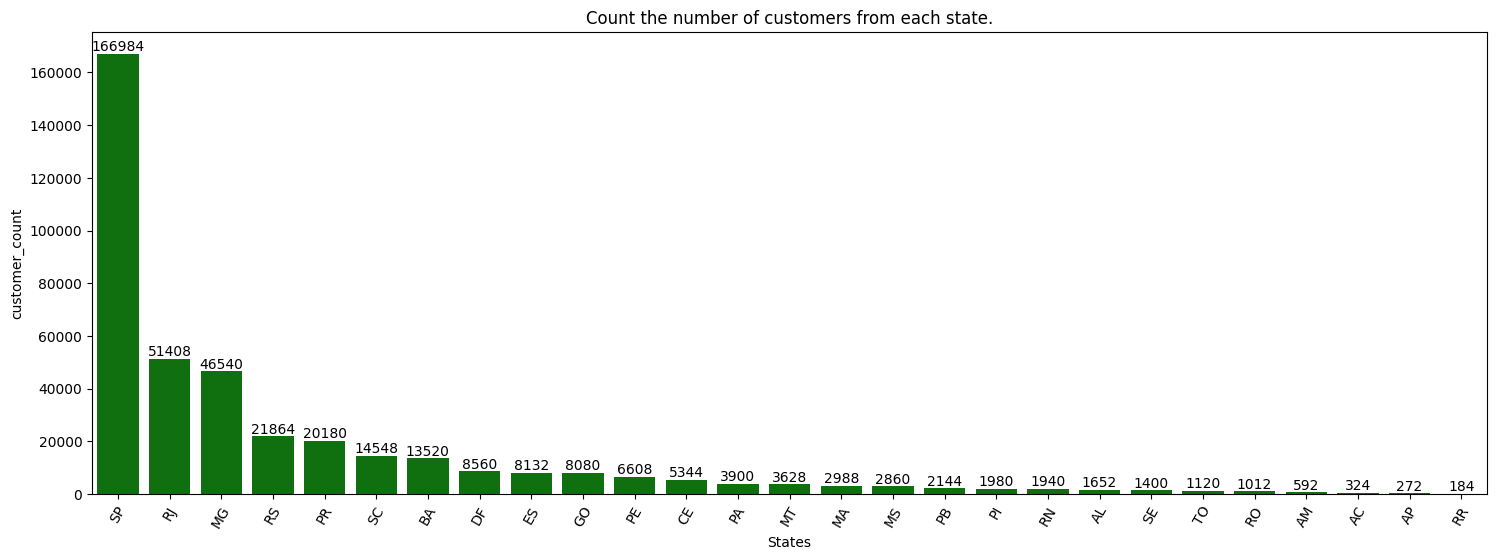

In [96]:
query = """select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["State","Customer_count"])
df = df.sort_values(by = "Customer_count", ascending = False)

plt.figure(figsize = (18,6))
plt.bar(df["State"], df["Customer_count"])
ax = sns.barplot(x = df["State"], y = df["Customer_count"], data = df, color ="Green" )
ax.bar_label(ax.containers[0])

plt.xticks(rotation = 60)
plt.xlabel("States")
plt.ylabel("customer_count")
plt.title("Count the number of customers from each state.")           
plt.show()                                                                                              

# 6. Calculate the number of orders per month in 2018.

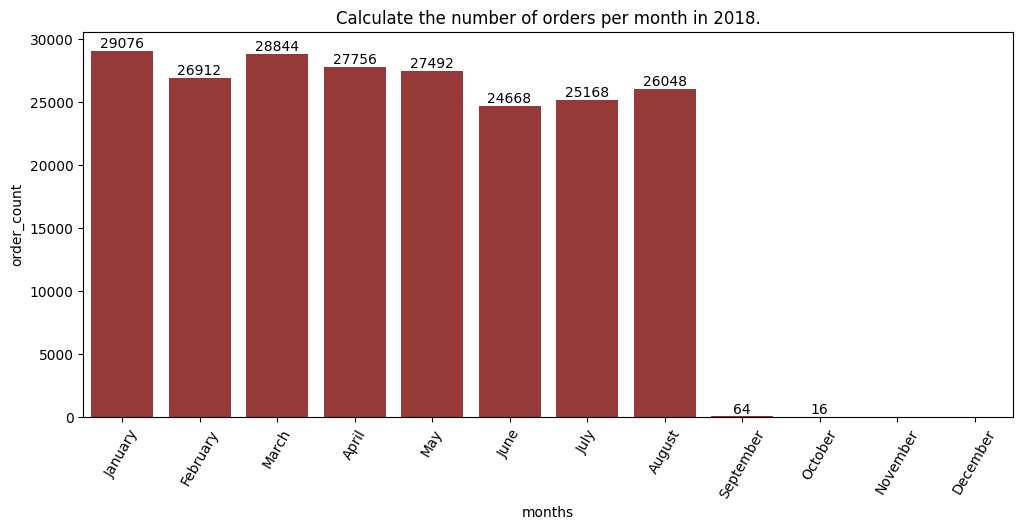

In [2]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize = (12,5))
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "brown")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 60)
plt.title("Calculate the number of orders per month in 2018.") 

plt.show()


In [39]:
import pandas as pd
df = pd.read_csv(file_path)



# 7. Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc  
"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["Customer_City","Ave_Order"])
df.head(10)



,Customer_City,Ave_Order
0,padre carvalho,84.00
1,celso ramos,78.00
2,datas,72.00
3,candido godoi,72.00
4,matias olimpio,60.00
5,cidelandia,48.00
6,curralinho,48.00
7,picarra,48.00
8,morro de sao paulo,48.00
9,teixeira soares,48.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales_Percentage"])
df.head(10)


,Category,Sales_Percentage
0,BED TABLE BATH,128.37
1,HEALTH BEAUTY,124.23
2,COMPUTER ACCESSORIES,118.83
3,FURNITURE DECORATION,107.20
4,WATCHES PRESENT,107.13
5,SPORT LEISURE,104.35
6,HOUSEWARES,82.06
7,AUTOMOTIVE,63.89
8,GARDEN TOOLS,62.84
9,COOL STUFF,58.44


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [20]:
import numpy as np

query = """ select upper(products.product_category) category,
count(order_items.product_id),
round(avg(order_items.price),2) price
from products join order_items
on products.product_id = order_items.product_id
group by category order by price desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Count_Products", "Avg_Price"])
df.head(10)

arr1 = df["Count_Products"]
arr2 = df["Avg_Price"]
a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157564


# 10. Calculate the total revenue generated by each seller, and rank them by revenue

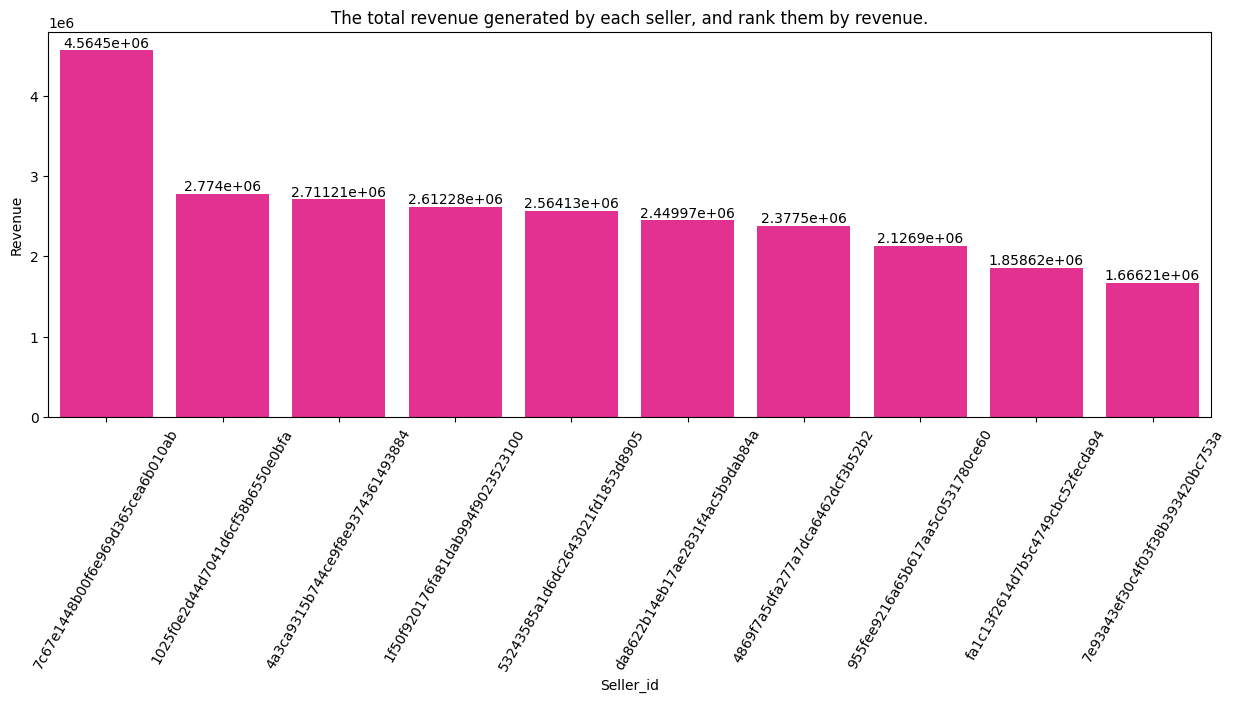

In [35]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from(select order_items.seller_id,
round(sum(payments.payment_value),2)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id","Revenue", "Rank"])
df = df.head(10)
plt.figure(figsize = (15,5))
ax = sns.barplot(x = df["Seller_id"], y = df["Revenue"], data = df, color = "deeppink")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 60)
plt.title("The total revenue generated by each seller, and rank them by revenue.") 

plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [7]:
query = """  select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id","Timestamp","Price","Mov_Avg"])
df.head(10)

,Customer_id,Timestamp,Price,Mov_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
9,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


# 12. Calculate the cumulative sales per month for each year.

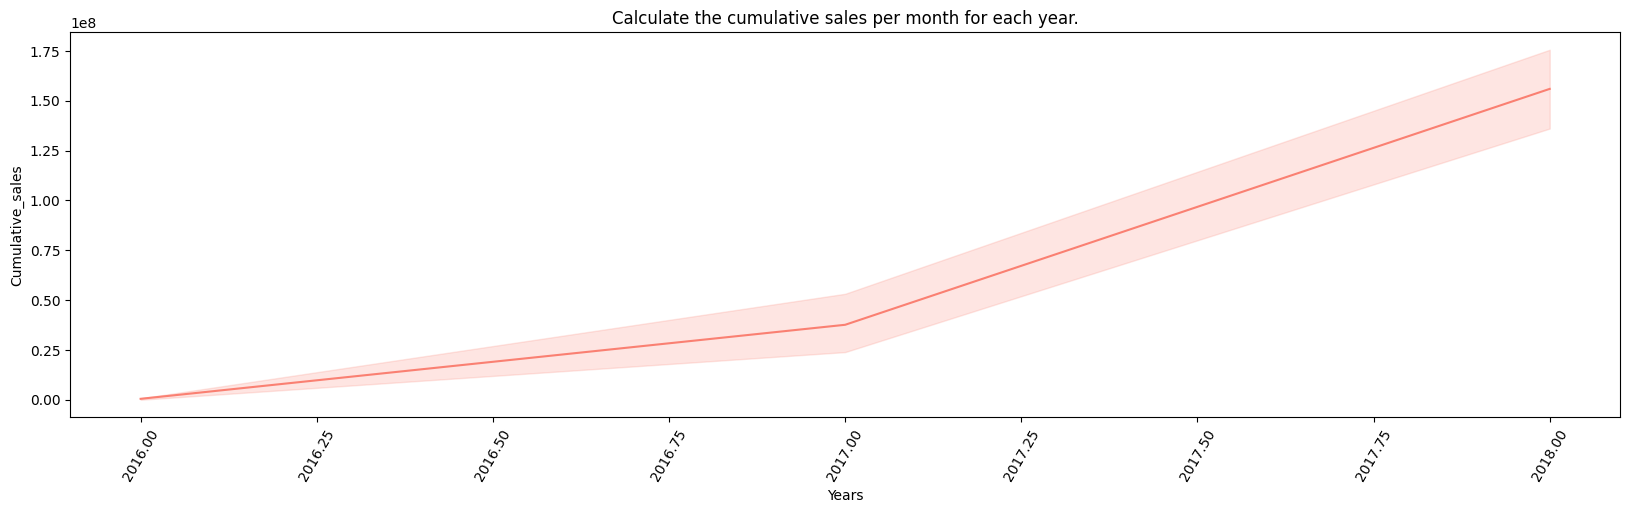

In [28]:
query = """  select years, months, payment, sum(payment)
over (order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as Payment 
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Months","Payment","Cumulative_sales"])
df = df.head(30)
plt.figure(figsize = (20,5))
ax = sns.lineplot(x = df["Years"], y = df["Cumulative_sales"], data = df, color = "salmon")

plt.xticks(rotation = 60)
plt.title("Calculate the cumulative sales per month for each year.") 

plt.show()
                                   

# 13. Calculate the year-over-year growth rate of total sales.


In [37]:
query = """with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as Payment 
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, payment, lag(payment,1) over(order by years) previous_year from a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Sales","previous_year"])
df

,Years,Sales,previous_year
0,2016,7.123481e+05,NaN
1,2017,8.699696e+07,712348.08
2,2018,1.043972e+08,86996960.74


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [4]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp<
date_add(first_order, interval 10 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b 
on a.customer_id = b.customer_id
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


# 15.Identify the top 3 customers who spent the most money in each year.

In [6]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
round(sum(payments.payment_value),2) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank <=3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Customer_id","Payment","Rank"])
df

,Years,Customer_id,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,17082.60,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,16808.88,2
2,2016,4a06381959b6670756de02e07b83815f,14733.36,3
3,2017,1617b1357756262bfa56ab541c47bc16,163968.96,1
4,2017,c6e2731c5b391845f6800c97401a43a9,83151.72,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,80719.92,3
6,2018,ec5b2ba62e574342386871631fafd3fc,87298.56,1
7,2018,f48d464a0baaea338cb25f816991ab1f,83066.52,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,57713.28,3


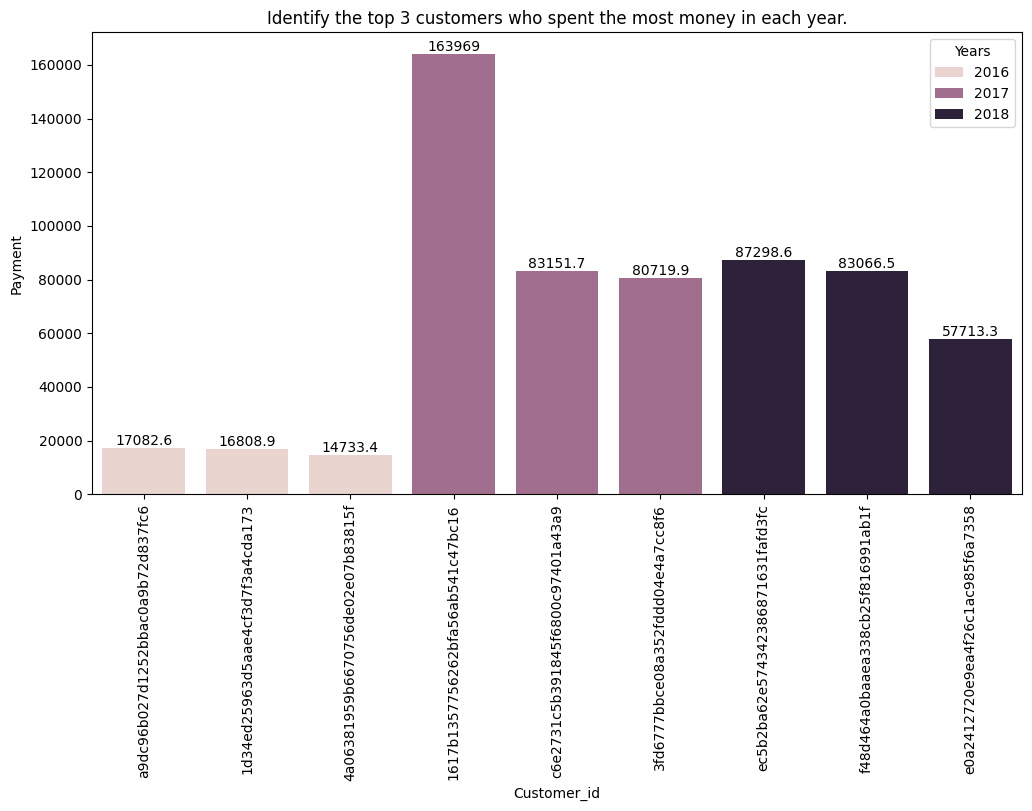

In [18]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
round(sum(payments.payment_value),2) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank <=3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Customer_id","Payment","Rank"])
plt.figure(figsize = (12,6))
ax = sns.barplot(x = df["Customer_id"], y = df["Payment"], data = df, hue = "Years")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.xticks(rotation = 90)
plt.title("Identify the top 3 customers who spent the most money in each year.")
plt.show()
